In [1]:
# 1. Move back to a safe, existing directory
%cd /content

# 2. (Optional) Clean up the old repo if it’s still hanging around
!rm -rf Hashim

# 3. Clone again
!git clone https://github.com/nurmaton/Hashim.git

# 4. Enter the new repo
%cd Hashims root

%cd /content/Hashim

# 3. Verify you see setup.py
!ls
# → should list setup.py, jax_ib/, README.md, etc.

# 4. Install in editable mode
!pip install -e .

/content
Cloning into 'Hashim'...
remote: Enumerating objects: 291, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 291 (delta 37), reused 22 (delta 22), pack-reused 243 (from 1)
Receiving objects: 100% (291/291), 1.58 MiB | 17.18 MiB/s, done.
Resolving deltas: 100% (189/189), done.
[Errno 2] No such file or directory: 'Hashims root'
/content
/content/Hashim
jax_ib	LICENSE  README.md  setup.py
Obtaining file:///content/Hashim
  Preparing metadata (setup.py) ... done
  Running setup.py develop for jax_ib


In [14]:
import jax
import jax.numpy as jnp

# --- FIX ---
# Monkey-patch the missing 'KeyArray' attribute that the old jax_ib library expects.
# In modern JAX, a key is just a regular array.
jax.random.KeyArray = jnp.ndarray
# --- END FIX ---

# Now the original imports will work
import jax_ib
from jax_ib.base import particle_class as pc
import jax_ib.base as ib
import jax_cfd.base as cfd
import jax_ib.MD as MD
from jax import random
from jax_md import space, quantity
from jax_ib.base import kinematics as ks
from jax.random import uniform as random_uniform
from jax_ib.base import grids
from jax_ib.base import boundaries
from jax_ib.base import advection,finite_differences
from jax_ib.base import IBM_Force,convolution_functions,particle_motion

<font size="5"> Flow Problem Setup <font size="5">

In [108]:
#-- Flow conditions
density = 1.0
viscosity = 0.05
dt=5e-4
inner_steps = 1000
outer_steps = 10


# --- NEW PENALTY IBM PARAMETERS ---
stiffness = 10000    # Spring stiffness (Kp). This is a crucial parameter to tune.
total_mass = 1   # Total mass of the immersed object.
gravity = 10      # Gravitational acceleration (e.g., 9.81 if you want sedimentation)
sigma = 0.0      # Surface tension coefficient.

#-- Domain and Grid Setup
domain = ((0,15.),(0,15.0))
size=(600,600)
grid = grids.Grid(size, domain=domain)

#-- Simplified CFD Boundary condition parameters (Periodic)
# This replaces the more complex setup, as our boundaries are not time-dependent.
velocity_bc = (boundaries.periodic_boundary_conditions(ndim=2),
               boundaries.periodic_boundary_conditions(ndim=2))

#-- Convection Scheme
def convect(v):
  return tuple(
    advection.advect_upwind(u, v, dt) for u in v)

#-- Initial velocity profile (Fluid at Rest)
vx_fn = lambda x, y: jnp.zeros_like(x + y)
vy_fn = lambda x, y: jnp.zeros_like(x + y)

velocity_fns = (vx_fn, vy_fn)
v0 = tuple(grid.eval_on_mesh(v_fn, offset) for v_fn, offset in zip(velocity_fns, grid.cell_faces))

v0 = tuple(
      grids.GridVariable(u, bc) for u, offset,
      bc in zip(v0, grid.cell_faces, velocity_bc))

#-- Initial Pressure Profile
pressure0 = grids.GridVariable(grids.GridArray(jnp.zeros_like(v0[0].data), grid.cell_center, grid), boundaries.get_pressure_bc_from_velocity(v0))

<font size="5"> Immersed Boudary Kinematics <font size="5">

In [114]:
#-- Immersed objects

# Immersed Objects Geometry and Initial locations

def foil_XY_ELLIPSE(geometry_param, theta_dummy):
    """
    Generates the coordinates of an ellipse using a parametric equation.
    This provides more evenly spaced points than the previous version.
    """
    A = geometry_param[0]  # Semi-major axis
    B = geometry_param[0]  # Semi-minor axis
    ntheta = 150 # Number of points on the boundary

    # Generate evenly spaced angles
    angle = jnp.linspace(0, 2 * jnp.pi, ntheta, endpoint=False)

    # Parametric equations for an ellipse
    x = A * jnp.cos(angle)
    y = B * jnp.sin(angle)
    return x, y

# --- NEW INITIALIZATION LOGIC for a Deformable Particle ---
particle_geometry_param = jnp.array([[0.5, 0.06],])
particle_center_position = jnp.array([[domain[0][1]*0.75, domain[1][1]/2],])
Shape_fn = foil_XY_ELLIPSE

# Generate the initial shape coordinates in the body's reference frame
# A dummy grid is used to get the number of points from the shape function.
Grid_p = pc.Grid1d(150, domain=(0, 2*jnp.pi))
xp0_body, yp0_body = Shape_fn(particle_geometry_param[0], Grid_p.mesh())

# In your "Immersed Boundary Kinematics" cell
# After generating xp0_body, yp0_body
angle_rad = 0.1 # A small initial tilt of about 6 degrees
xp_rotated = xp0_body * jnp.cos(angle_rad) - yp0_body * jnp.sin(angle_rad)
yp_rotated = xp0_body * jnp.sin(angle_rad) + yp0_body * jnp.cos(angle_rad)


# Initial positions: fluid markers (xp, yp) and mass markers (Ym_x, Ym_y) start
# at the same location, translated to the particle's center position.
initial_xp = xp0_body + particle_center_position[0, 0]
initial_yp = yp0_body + particle_center_position[0, 1]

# Initial velocities for the mass markers are zero since the simulation starts from rest.
initial_Vm_x = jnp.zeros_like(initial_xp)
initial_Vm_y = jnp.zeros_like(initial_xp)

# Calculate mass per marker from the total mass defined in the previous cell.
num_markers = len(initial_xp)
mass_per_marker = total_mass / num_markers

# Create the final particle object with its full dynamic state.
# This object will be passed to the simulation loop.
# Create the particle object
deformable_particle = pc.particle(
    xp=initial_xp, yp=initial_yp,
    Ym_x=initial_xp.copy(), Ym_y=initial_yp.copy(),
    Vm_x=initial_Vm_x, Vm_y=initial_Vm_y,
    mass_per_marker=mass_per_marker,
    stiffness=stiffness,
    sigma=sigma,
    particle_center=particle_center_position,
    geometry_param=particle_geometry_param,
    Grid=Grid_p,
    shape=Shape_fn
)

# The 'particles' object is now a container holding a list of particle objects.
# This structure is flexible for future multi-particle simulations.
particles_container = pc.particle_lista(particles=[deformable_particle])

<font size="5"> Simulation Setup <font size="5">

In [115]:
#-- Setup Pytree Variable to be looped over during integration steps

Intermediate_calcs = [0] ## If one is interested to perform post-calculation without the need to save large trajectories
Step_counter = 0
MD_state = [0] # Needed when combining Brownian integration with the Immersed Boundary simulation

# Use the new 'particles_container' we created in the previous cell
all_variables = pc.All_Variables(particles_container, v0, pressure0, Intermediate_calcs, Step_counter, MD_state)

#-- IB force coupling functions for the Deformable Model
def internal_post_processing(all_variables, dt):
    # This function can be used for any calculations you want to perform inside the time-step loop.
    return all_variables

# Force convolution kernel (The delta function itself remains the same)
# We create a simpler lambda that matches the new API.
discrete_delta = lambda dist, center, width: convolution_functions.delta_approx_logistjax(dist, center, width)

# The surf_fn is no longer needed because we are not interpolating velocity for direct forcing.

# --- NEW, UPDATED IBM FORCING AND UPDATE FUNCTIONS ---

# The IBM forcing function now calculates the penalty/tension force from the particle's state.
# The `v` argument passed by the solver is the entire `all_variables` pytree.
IBM_forcing = lambda v, dt: IBM_Force.calc_IBM_force_NEW_MULTIPLE(v, discrete_delta, dt)

# The particle update function now calls our new massive, deformable particle stepper.
# We use a lambda to pass the 'gravity' parameter defined in the first cell.
Update_position = lambda v, dt: particle_motion.update_massive_deformable_particle(v, dt, gravity_g=gravity)


# --- The main solver call now uses the new dynamic functions ---
step_fn = cfd.funcutils.repeated(
    ib.equations.semi_implicit_navier_stokes_timeBC(
        density=density,
        viscosity=viscosity,
        dt=dt,
        grid=grid,
        convect=convect,
        pressure_solve= ib.pressure.solve_fast_diag,
        forcing=None,
        time_stepper= ib.time_stepping.forward_euler_updated,
        IBM_forcing = IBM_forcing,          # Using the new penalty/tension force function
        Updating_Position = Update_position,  # Using the new deformable update function
        Drag_fn = internal_post_processing,
        ),
    steps=inner_steps)

# The rollout function to run the simulation and collect the trajectory remains the same.
rollout_fn = cfd.funcutils.trajectory(
        step_fn, outer_steps, start_with_input=True)

final_result, trajectory = jax.device_get(rollout_fn(all_variables))

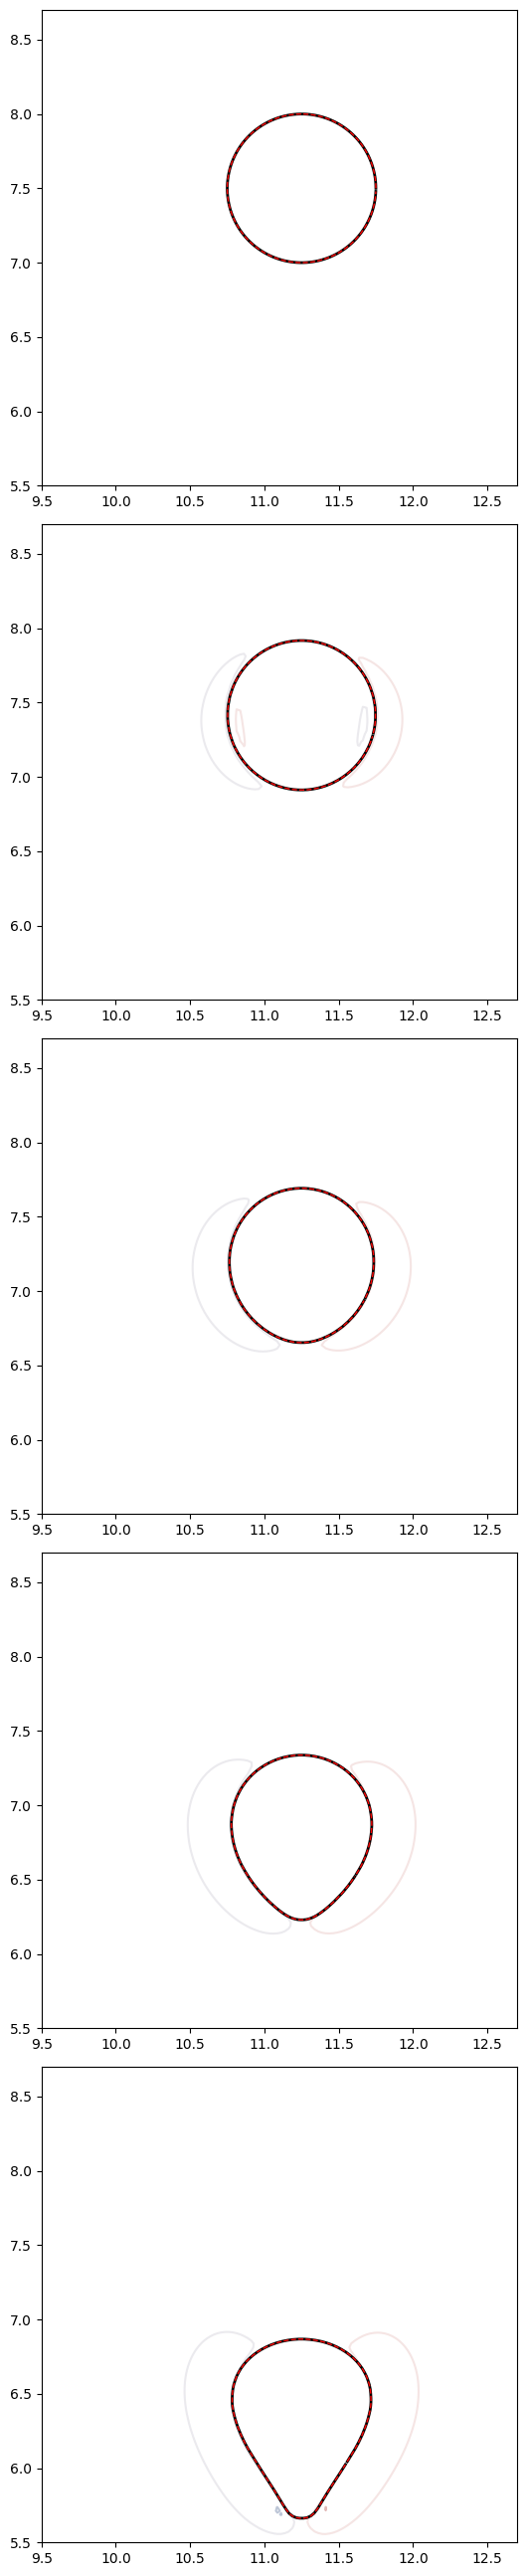

In [116]:
import matplotlib.pyplot as plt
import seaborn
import numpy as np

# Grid mesh for plotting
X,Y = grid.mesh(grid.cell_center)

def calc_vorticity(trajectory, idx):
    """
    Calculates the vorticity at a specific time step from the trajectory.
    This is now updated for static periodic boundary conditions.
    """
    # --- FIX 1: Create a simple periodic BC for post-processing ---
    # We no longer need the old, non-existent variables like vx_bc or bc_fns.
    vel_bc = (boundaries.periodic_boundary_conditions(ndim=2),
              boundaries.periodic_boundary_conditions(ndim=2))

    # Reconstruct the GridVariable for this specific time step's velocity data
    velocity = (grids.GridVariable(grids.GridArray(trajectory.velocity[0].data[idx], trajectory.velocity[0].offset, trajectory.velocity[0].grid), vel_bc[0]),
                grids.GridVariable(grids.GridArray(trajectory.velocity[1].data[idx], trajectory.velocity[1].offset, trajectory.velocity[1].grid), vel_bc[1]))

    # Calculate vorticity using finite differences
    return finite_differences.central_difference(velocity[1], axis=0).data - finite_differences.central_difference(velocity[0], axis=1).data

# --- Main Plotting Loop ---
fig,ax = plt.subplots(figsize=(12, 26), nrows=max(1, outer_steps // 2))

# Ensure 'ax' is an array even if nrows is 1
if outer_steps // 2 == 1:
    ax = [ax]

counter = 0
for idx in range(0, outer_steps, 2):
    # Plot the vorticity field
    ax[counter].contour(X, Y, calc_vorticity(trajectory, idx), cmap=seaborn.color_palette("vlag", as_cmap=True), levels=np.linspace(-10, 10, 10))

    # --- FIX 2: Get the DEFORMED particle shape directly from the trajectory ---
    # This replaces the old kinematic reconstruction logic.

    # Access the particle's state at the current time step 'idx'
    particle_state_at_idx = trajectory.particles.particles[0]

    # Get the current, deformed coordinates of the fluid markers
    xp = particle_state_at_idx.xp[idx]
    yp = particle_state_at_idx.yp[idx]

    # Plot the deformed particle shape
    ax[counter].set_xlim([9.5, 12.7])
    ax[counter].set_ylim([5.5, 8.7])
    ax[counter].plot(xp, yp, 'k-', linewidth=2.0)

    # To see both the fluid and mass markers, you could also plot the Y markers:
    Ym_x = particle_state_at_idx.Ym_x[idx]
    Ym_y = particle_state_at_idx.Ym_y[idx]
    ax[counter].plot(Ym_x, Ym_y, 'r--', linewidth=1.0) # Mass markers in dashed red


    ax[counter].set_aspect('equal', adjustable='box')

    counter += 1

plt.tight_layout() # Adjusts subplot params for a tight layout.

plt.show()